In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle
import seaborn as sns

# Initial-preprocessing

In [39]:
import joblib

# Load in the dataset
spotify_data = pd.read_csv('../1_data/raw/dataset.csv', index_col=0)

# Select columns of interest
selected_spotify_data = spotify_data[['danceability', 'energy', 'loudness',
                                      'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                                      'valence', 'tempo', 'track_genre']]

# Drop any Na's
selected_spotify_data = selected_spotify_data.dropna()

# Genre to category mapping for playlist creation
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music',
    'house': 'Electronic Dance Music',
    'electro': 'Electronic Dance Music',
    'trance': 'Electronic Dance Music',
    'techno': 'Electronic Dance Music',
    'dubstep': 'Electronic Dance Music',
    'drum-and-bass': 'Electronic Dance Music',
    'deep-house': 'Electronic Dance Music',
    'detroit-techno': 'Electronic Dance Music',
    'minimal-techno': 'Electronic Dance Music',
    'progressive-house': 'Electronic Dance Music',
    'breakbeat': 'Electronic Dance Music',

    # Rock
    'alt-rock': 'Rock',
    'rock': 'Rock',
    'indie': 'Rock',
    'indie-pop': 'Rock',
    'punk': 'Rock',
    'punk-rock': 'Rock',
    'hard-rock': 'Rock',
    'metal': 'Rock',
    'heavy-metal': 'Rock',
    'black-metal': 'Rock',
    'death-metal': 'Rock',
    'grunge': 'Rock',

    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B',
    'r-n-b': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',

    # Pop
    'pop': 'Pop',
    'electro-pop': 'Pop',
    'synth-pop': 'Pop',
    'k-pop': 'Pop',
    'pop-film': 'Pop',
    'power-pop': 'Pop',

    # Latin & Reggae/Dancehall
    'latin': 'Latin & Reggae/Dancehall',
    'reggaeton': 'Latin & Reggae/Dancehall',
    'salsa': 'Latin & Reggae/Dancehall',
    'samba': 'Latin & Reggae/Dancehall',
    'reggae': 'Latin & Reggae/Dancehall',
    'dancehall': 'Latin & Reggae/Dancehall',

    # Funk and Disco
    'funk': 'Funk and Disco',
    'disco': 'Funk and Disco',
    'groove': 'Funk and Disco',
}

# Map each track to a category
selected_spotify_data['music_category'] = selected_spotify_data['track_genre'].apply(
    lambda x: genre_to_category.get(x, 'Other'))

# Filter out 20k samples of 'Other' category
other_category_samples = selected_spotify_data[selected_spotify_data['music_category'] == 'Other'].sample(n=20000, random_state=50)

# Concatenate the filtered 'Other' samples with the rest of the data
selected_spotify_data = pd.concat([selected_spotify_data[selected_spotify_data['music_category'] != 'Other'], other_category_samples])

# Save the selected data to a CSV file
selected_spotify_data.to_csv('../1_data/derived/selected_spotify_data.csv')


# Split data into features (X) and target variable (y)
X = selected_spotify_data.drop(columns=['music_category', 'track_genre']).to_numpy()
y = selected_spotify_data['music_category']

# Encode the categorical target variable y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a StandardScaler instance
scaler = StandardScaler(with_mean=True)

# Split data into training testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=100)

# Fit and transform train data
X_train_normalised = scaler.fit_transform(X_train)

# Transform test data using scalar trained on train data
X_test_normalised = scaler.transform(X_test)

# Save X_train_normalised to CSV
pd.DataFrame(X_train_normalised).to_csv('../1_data/derived/X_train_normalised.csv', index=False)

# Save X_test_normalised to CSV
pd.DataFrame(X_test_normalised).to_csv('../1_data/derived/X_test_normalised.csv', index=False)

# Save y_train to CSV
pd.DataFrame(y_train).to_csv('../1_data/derived/y_train.csv', index=False, header=['track_genre_encoded'])

# Save y_test to CSV
pd.DataFrame(y_test).to_csv('../1_data/derived/y_test.csv', index=False, header=['track_genre_encoded'])

# Save the scaler object
joblib.dump(scaler, '../1_data/derived/scaler_values.joblib')

# Save the LabelEncoder object
joblib.dump(label_encoder, '../1_data/derived/label_encoder.joblib')

['../1_data/derived/label_encoder.joblib']

In [40]:
# Load the scaler object
scaler_loaded = joblib.load('../1_data/derived/scaler_values.joblib')

X_new_transformed = scaler_loaded.transform(X_test_normalised)

# Load the LabelEncoder object
label_encoder_loaded = joblib.load('../1_data/derived/label_encoder.joblib')

y_new_encoded = label_encoder_loaded.transform(y)

In [41]:
# Get unique encoded labels and their corresponding original labels
unique_encoded_labels = np.unique(y_encoded)
original_labels = label_encoder.inverse_transform(unique_encoded_labels)

# Print unique encoded labels along with their corresponding original labels
print("Unique encoded labels with corresponding original labels:")
for encoded_label, original_label in zip(unique_encoded_labels, original_labels):
    print(f"Encoded label: {encoded_label}, Original label: {original_label}")

Unique encoded labels with corresponding original labels:
Encoded label: 0, Original label: Electronic Dance Music
Encoded label: 1, Original label: Funk and Disco
Encoded label: 2, Original label: Hip-Hop and R&B
Encoded label: 3, Original label: Latin & Reggae/Dancehall
Encoded label: 4, Original label: Other
Encoded label: 5, Original label: Pop
Encoded label: 6, Original label: Rock


# Analysis of dataset

In [8]:
selected_spotify_data

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,music_category
2000,0.588,0.521,-9.461,0.0329,0.06780,0.149000,0.1230,0.3370,85.012,alt-rock,Rock
2001,0.705,0.712,-6.156,0.0385,0.01020,0.000855,0.1000,0.6200,97.512,alt-rock,Rock
2002,0.575,0.568,-5.509,0.0300,0.04840,0.000417,0.2860,0.3700,93.986,alt-rock,Rock
2003,0.612,0.807,-2.810,0.0336,0.04950,0.017700,0.1010,0.3980,124.053,alt-rock,Rock
2004,0.551,0.881,-6.099,0.0542,0.18600,0.079100,0.1520,0.3870,88.036,alt-rock,Rock
...,...,...,...,...,...,...,...,...,...,...,...
66944,0.813,0.712,-5.104,0.2810,0.04620,0.000000,0.0433,0.5870,179.948,kids,Other
84351,0.332,0.786,-4.112,0.0334,0.02950,0.941000,0.4180,0.4440,139.988,psych-rock,Other
113432,0.161,0.897,-22.398,0.0804,0.00163,0.920000,0.8630,0.0247,110.367,world-music,Other
94077,0.682,0.598,-5.694,0.2640,0.05750,0.000000,0.2990,0.8230,103.791,sad,Other


In [9]:
descriptive_stats = selected_spotify_data.describe()
print(descriptive_stats)

       danceability        energy      loudness   speechiness  acousticness  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.582464      0.690168     -7.429974      0.082803      0.242586   
std        0.169514      0.225229      4.230416      0.093135      0.296308   
min        0.000000      0.000019    -46.251000      0.000000      0.000000   
25%        0.472000      0.553000     -8.999000      0.037000      0.008070   
50%        0.597000      0.731000     -6.451000      0.050900      0.095400   
75%        0.710000      0.873000     -4.731000      0.086400      0.416000   
max        0.983000      1.000000      1.821000      0.962000      0.996000   

       instrumentalness      liveness       valence         tempo  
count      60000.000000  60000.000000  60000.000000  60000.000000  
mean           0.146966      0.208761      0.482740    123.438123  
std            0.297672      0.184317      0.255706     29.007462  
min            0

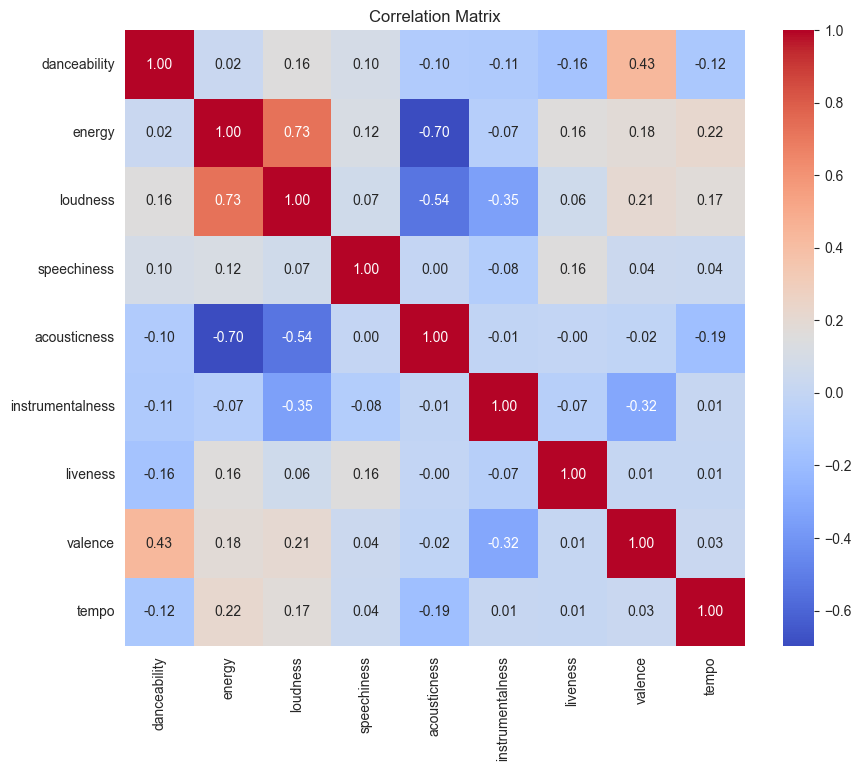

In [13]:
# Select all columns except the last one (genre)
columns_to_include = selected_spotify_data.iloc[:, :-2]

# Compute correlation matrix
correlation_matrix = columns_to_include.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

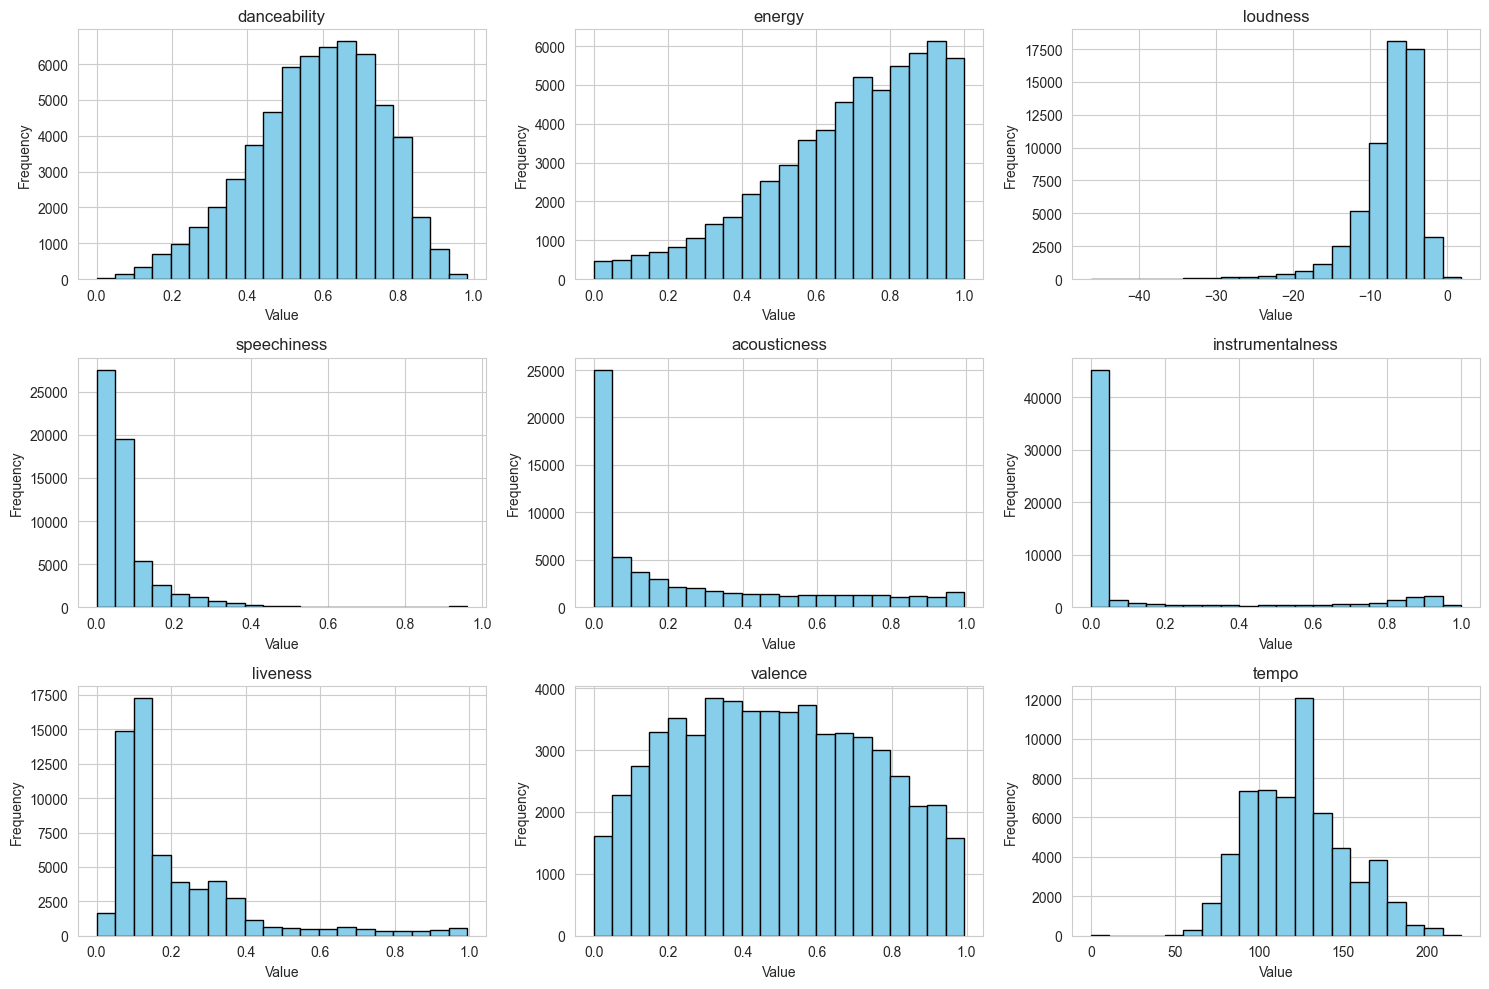

In [15]:
import matplotlib.pyplot as plt
import math

# Select all columns except the last one (genre)
columns_to_include = selected_spotify_data.iloc[:, 0:-2]

# Determine the number of rows and columns for the subplot grid
num_columns = columns_to_include.shape[1]
num_rows = math.ceil(num_columns / 3)

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 10))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(columns_to_include.columns):
    ax = axes[i]  # Get the current axis
    ax.hist(columns_to_include[column], bins=20, color='skyblue', edgecolor='black', zorder=2)
    ax.set_title(column)  # Set the title of the subplot
    ax.set_xlabel('Value')  # Set the x-axis label
    ax.set_ylabel('Frequency')  # Set the y-axis label
    ax.grid(True, zorder=0)  # Add gridlines

# Hide empty subplots if necessary
for i in range(num_columns, num_rows * 3):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


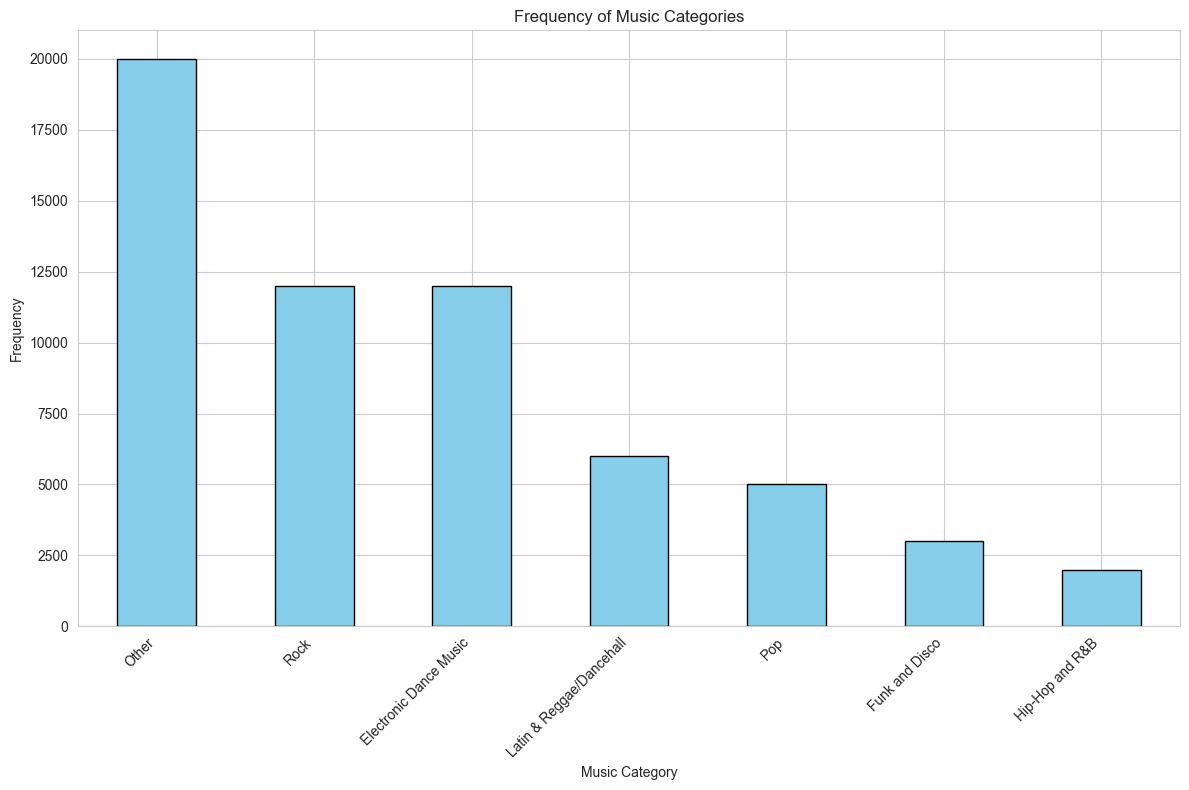

In [16]:
# Count the frequencies of each category
category_counts = selected_spotify_data['music_category'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Music Categories')
plt.xlabel('Music Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()

# Modelling

# KNN

In [52]:
# Load in the dataset
X_train = pd.read_csv('../1_data/derived/X_train_normalised.csv').to_numpy()
X_test = pd.read_csv('../1_data/derived/X_test_normalised.csv').to_numpy()
y_train = pd.read_csv('../1_data/derived/y_train.csv').to_numpy().ravel()
y_test = pd.read_csv('../1_data/derived/y_test.csv').to_numpy().ravel()

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

np.random.seed(10)

def knn_cross_validation(data_x, data_y, ks=np.arange(1, 40)[::2], ps=[1, 2], weights=['uniform', 'distance']):
    """
    Perform k-Nearest Neighbors cross-validation for classification.

    Parameters:
        data_x (numpy.ndarray): Input features.
        data_y (numpy.ndarray): Target labels.
        ks (array-like, optional): List of numbers of neighbors to consider. Defaults to np.arange(1, 40)[::2].
        ps (list, optional): List of Minkowski distances parameter values. Defaults to [1, 2].
        weights (list, optional): List of weight functions used in prediction. Defaults to ['uniform', 'distance'].

    Returns:
        dict: Dictionary containing mean cross-validation scores for each combination of parameters.
    """
    # Dictionary to store mean cross-validation scores for each combination
    mean_cv_scores_dict = {}

    # Loop over each combination of weight function and Minkowski distance parameter
    for weight in weights:
        for p in ps:
            print(f'Started: {weight} with distance {p}') 
            
            mean_cv_scores = []  # List to store mean cross-validation scores for the current combination
            
            # Loop over each number of neighbors
            for i, parameter in enumerate(ks):
                # Initialize KNN classifier model with the current combination of parameters
                KNN = KNeighborsClassifier(n_neighbors=parameter, weights=weight, algorithm="auto", metric="minkowski", p=p)
                
                # Perform k-fold Cross-Validation
                kf = KFold(n_splits=10)  # Split data into 2 folds
                
                # List to store cross-validation scores
                cv_scores = []
                
                # Iterate over each fold and calculate cross-validation score
                for train_index, val_index in kf.split(data_x):
                    X_train, X_val = data_x[train_index], data_x[val_index]
                    y_train, y_val = data_y[train_index], data_y[val_index]
                    
                    # Fit KNN classifier model
                    KNN.fit(X_train, y_train)
                    
                    # Predict on the validation set
                    y_pred = KNN.predict(X_val)
                    
                    # Calculate accuracy
                    accuracy = accuracy_score(y_val, y_pred)
                    
                    # Append accuracy to the list of cross-validation scores
                    cv_scores.append(accuracy)
                
                # Calculate mean cross-validation score
                mean_cv_score = np.mean(cv_scores)
                mean_cv_scores.append(mean_cv_score)
                
                print(f'Parameter K: {i}/{len(ks)}')  
            
            # Store the mean cross-validation scores for the current combination in the dictionary
            mean_cv_scores_dict[(weight, p)] = mean_cv_scores
            
            print(f'Finished: {weight} with distance {p}') 
    
    return mean_cv_scores_dict

ks=np.arange(1, 40)[::2]

mean_cv_scores_dict = knn_cross_validation(X_train, y_train, ks)

Started: uniform with distance 1
Parameter K: 0/20
Parameter K: 1/20
Parameter K: 2/20
Parameter K: 3/20
Parameter K: 4/20
Parameter K: 5/20
Parameter K: 6/20
Parameter K: 7/20
Parameter K: 8/20
Parameter K: 9/20
Parameter K: 10/20
Parameter K: 11/20
Parameter K: 12/20
Parameter K: 13/20
Parameter K: 14/20
Parameter K: 15/20
Parameter K: 16/20
Parameter K: 17/20
Parameter K: 18/20
Parameter K: 19/20
Finished: uniform with distance 1
Started: uniform with distance 2
Parameter K: 0/20
Parameter K: 1/20
Parameter K: 2/20
Parameter K: 3/20
Parameter K: 4/20
Parameter K: 5/20
Parameter K: 6/20
Parameter K: 7/20
Parameter K: 8/20
Parameter K: 9/20
Parameter K: 10/20
Parameter K: 11/20
Parameter K: 12/20
Parameter K: 13/20
Parameter K: 14/20
Parameter K: 15/20
Parameter K: 16/20
Parameter K: 17/20
Parameter K: 18/20
Parameter K: 19/20
Finished: uniform with distance 2
Started: distance with distance 1
Parameter K: 0/20
Parameter K: 1/20
Parameter K: 2/20
Parameter K: 3/20
Parameter K: 4/20
Pa

In [92]:
mean_cv_scores_dict

{('uniform', 1): [0.5302941176470588,
  0.5160980392156862,
  0.5315294117647059,
  0.5350588235294118,
  0.5376470588235294,
  0.5377647058823529,
  0.5380392156862743,
  0.538843137254902,
  0.5384705882352941,
  0.5397058823529413,
  0.5382156862745097,
  0.5375686274509804,
  0.5372352941176469,
  0.5366274509803921,
  0.536078431372549,
  0.5357058823529413,
  0.5346666666666666,
  0.5339607843137254,
  0.5337254901960785,
  0.5327450980392157],
 ('uniform', 2): [0.5269999999999999,
  0.515156862745098,
  0.5286666666666667,
  0.5299411764705881,
  0.5317450980392158,
  0.5313921568627451,
  0.5319803921568627,
  0.5332156862745097,
  0.5329607843137254,
  0.5338627450980391,
  0.5340980392156863,
  0.5346470588235295,
  0.5329411764705883,
  0.5338627450980392,
  0.5325882352941177,
  0.5311960784313726,
  0.5310392156862745,
  0.5314117647058824,
  0.5315098039215685,
  0.5312156862745098],
 ('distance', 1): [0.5302941176470588,
  0.5451764705882353,
  0.5613529411764706,
  0.56

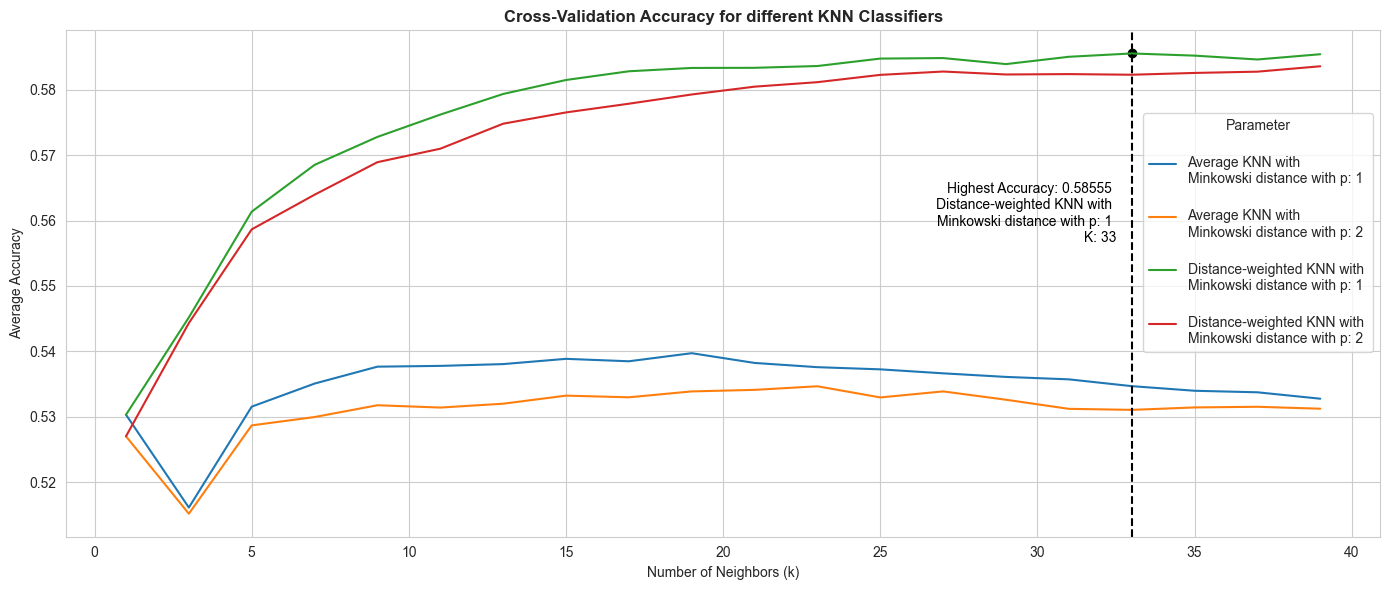

In [120]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


def plot_mean_cv_scores_list(mean_cv_scores_dicts, titles, ks):
    p_s=[1, 2]
    weights=['uniform', 'distance']
    
    num_plots = len(mean_cv_scores_dicts)
    
    fig, axs = plt.subplots(num_plots, 1, figsize=(14, 6*num_plots))
    
    for i, (mean_cv_scores_dict, title) in enumerate(zip(mean_cv_scores_dicts, titles)):
        max_accuracy = 0
        max_accuracy_k = None
        max_accuracy_weight = None
        max_accuracy_p = None
        
        for weight in weights:
            for p in p_s:
                # Extract mean cross-validation scores for the current combination
                mean_cv_scores = mean_cv_scores_dict[(weight, p)]
                
                # Find the maximum accuracy and its corresponding k value
                max_mean_cv_score = max(mean_cv_scores)
                max_mean_cv_score_k = ks[np.argmax(mean_cv_scores)]
                
                if max_mean_cv_score > max_accuracy:
                    max_accuracy = max_mean_cv_score
                    max_accuracy_k = max_mean_cv_score_k
                    max_accuracy_weight = weight
                    max_accuracy_p = p
                
                if weight == "distance":
                    axs.plot(ks, mean_cv_scores, label=f'\nDistance-weighted KNN with \nMinkowski distance with p: {p}')
                else:
                    axs.plot(ks, mean_cv_scores, label=f'\nAverage KNN with \nMinkowski distance with p: {p}')

        # Plot vertical line at the k value corresponding to the highest accuracy
        axs.axvline(x=max_accuracy_k, color='black', linestyle='--')
        
        axs.scatter(max_accuracy_k, max_accuracy, color = "black")
        # Add text mentioning the combination and the value of the highest accuracy
        if max_accuracy_weight == "distance":
            axs.text(max_accuracy_k-0.5 , max_accuracy *0.95,
                      f'Highest Accuracy: {max_accuracy:.5f} \nDistance-weighted KNN with \nMinkowski distance with p: {max_accuracy_p} \nK: {max_accuracy_k}', 
                     verticalalignment='bottom', horizontalalignment='right', color='black')
        else:
            axs.text(max_accuracy_k + 0.1, max_accuracy *0.95,
                      f'Highest Accuracy: {max_accuracy:.5f} \nAverage KNN with \nMinkowski distance with p: {max_accuracy_p} \nK: {max_accuracy_k}', 
                     verticalalignment='bottom', horizontalalignment='right', color='black')

        axs.set_title(title, fontweight="bold")
        axs.set_xlabel('Number of Neighbors (k)')
        axs.set_ylabel('Average Accuracy')
        axs.legend(loc='upper right', bbox_to_anchor=(1, 0.85), title = "Parameter")
        axs.grid(True)
    
    plt.tight_layout()
    
    # Save the plot as an image file with high resolution (300 dpi)
    plt.savefig("KNN_classifier_hyperparameter_tuning_plot.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return max_accuracy_p, max_accuracy_weight, max_accuracy_k

    
titles = ['Cross-Validation Accuracy for different KNN Classifiers']

max_accuracy_p, max_accuracy_weight, max_accuracy_k = plot_mean_cv_scores_list([mean_cv_scores_dict], titles, ks)


In [118]:
# Fit the best model on whole data
best_model_knn = KNeighborsClassifier(n_neighbors=max_accuracy_k, weights=max_accuracy_weight, algorithm="auto", metric="minkowski", p=max_accuracy_p)
best_model_knn.fit(X_train, y_train)

# Save model
# joblib.dump(best_model_knn, best_model_knn.joblib)


import pickle

# Save the model
with open("best_model_knn.pkl", "wb") as f:
    pickle.dump(best_model_knn, f)
    
# Load the model
with open("best_model_knn.pkl", "rb") as f:
    loaded_model = pickle.load(f)




# Now you can use the loaded_model for predictions
# For example:
# predictions = loaded_model.predict(X_test)

In [119]:
loaded_model

KNeighborsClassifier(n_neighbors=33, p=1, weights='distance')

# Decison Trees

In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

def tune_decision_tree_ccp_alpha_classifier(X_train_data, y_train_data, ccp_alpha_values, n_splits=5):
    """
    Tunes the 'ccp_alpha' hyperparameter of Decision Tree Classifier using K-Fold Cross-Validation.

    Parameters:
    - X_train_data (array-like): Training features.
    - y_train_data (array-like): Training labels.
    - ccp_alpha_values (array-like): List of values to try for the 'ccp_alpha' hyperparameter.
    - n_splits (int, optional): Number of folds for K-Fold Cross-Validation. Default is 5.

    Returns:
    - best_ccp_alpha (float): Best value found for the 'ccp_alpha' hyperparameter.
    - best_accuracy (float): Accuracy achieved by the best 'ccp_alpha'.
    - accuracy_values (dict): Dictionary containing average accuracy values for each 'ccp_alpha'.
    """

    accuracy_values = {}  # Dictionary to store average accuracy values for each ccp_alpha

    # Initialize K-Fold cross-validator
    kf = KFold(n_splits=n_splits)

    num_comb = len(ccp_alpha_values)
    i = 0
    # Loop through all values of ccp_alpha
    for ccp_alpha in ccp_alpha_values:
        accuracy_list = []  # List to store accuracy values for current ccp_alpha
        # Loop through each fold of K-Fold CV
        for train_index, val_index in kf.split(X_train_data):
            X_train, X_val = X_train_data[train_index], X_train_data[val_index]
            y_train, y_val = y_train_data[train_index], y_train_data[val_index]
            # Initialize the DecisionTreeClassifier with current ccp_alpha
            tree_classifier = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=50)
            # Fit the model to the training data
            tree_classifier.fit(X_train, y_train)
            # Predict on the validation set
            y_pred = tree_classifier.predict(X_val)
            # Calculate accuracy for this fold
            accuracy = accuracy_score(y_val, y_pred)
            accuracy_list.append(accuracy)
        # Calculate average accuracy across all folds for this ccp_alpha
        avg_accuracy = np.mean(accuracy_list)
        # Store the average accuracy value for this ccp_alpha
        accuracy_values[ccp_alpha] = avg_accuracy
        i += 1
        print(f'Done {i}/{num_comb}')

    # Find the best ccp_alpha based on the highest average accuracy
    best_ccp_alpha = max(accuracy_values, key=accuracy_values.get)
    best_accuracy = accuracy_values[best_ccp_alpha]

    print("Best ccp_alpha:", best_ccp_alpha)
    print("Accuracy (after tuning):", best_accuracy)

    return best_ccp_alpha, best_accuracy, accuracy_values

# Define lists of values for hyperparameters
ccp_alpha_values = np.logspace(np.log10(0.000001), np.log10(0.1), 200)
best_ccp_alpha, best_accuracy, accuracy_values = tune_decision_tree_ccp_alpha_classifier(X_train, y_train, ccp_alpha_values, n_splits=5)

Done 1/200
Done 2/200
Done 3/200
Done 4/200
Done 5/200
Done 6/200
Done 7/200
Done 8/200
Done 9/200
Done 10/200
Done 11/200
Done 12/200
Done 13/200
Done 14/200
Done 15/200
Done 16/200
Done 17/200
Done 18/200
Done 19/200
Done 20/200
Done 21/200
Done 22/200
Done 23/200
Done 24/200
Done 25/200
Done 26/200
Done 27/200
Done 28/200
Done 29/200
Done 30/200
Done 31/200
Done 32/200
Done 33/200
Done 34/200
Done 35/200
Done 36/200
Done 37/200
Done 38/200
Done 39/200
Done 40/200
Done 41/200
Done 42/200
Done 43/200
Done 44/200
Done 45/200
Done 46/200
Done 47/200
Done 48/200
Done 49/200
Done 50/200
Done 51/200
Done 52/200
Done 53/200
Done 54/200
Done 55/200
Done 56/200
Done 57/200
Done 58/200
Done 59/200
Done 60/200
Done 61/200
Done 62/200
Done 63/200
Done 64/200
Done 65/200
Done 66/200
Done 67/200
Done 68/200
Done 69/200
Done 70/200
Done 71/200
Done 72/200
Done 73/200
Done 74/200
Done 75/200
Done 76/200
Done 77/200
Done 78/200
Done 79/200
Done 80/200
Done 81/200
Done 82/200
Done 83/200
Done 84/200
D

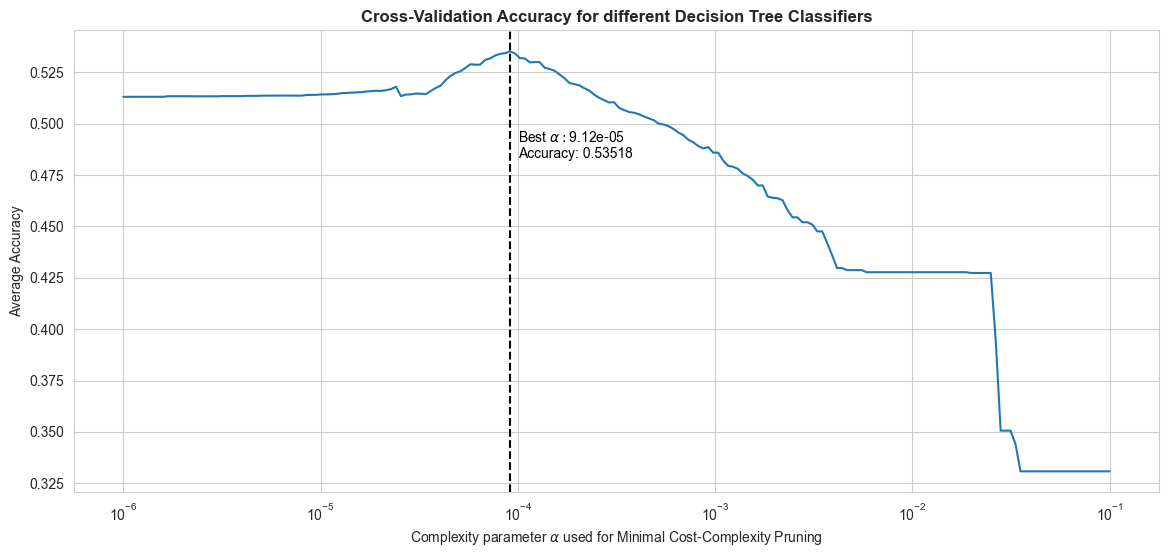

In [154]:
import matplotlib.pyplot as plt

def plot_accuracy_values(accuracy_values, best_ccp_alpha, best_accuracy):
    """
    Plots the average accuracy values for different ccp_alpha values.

    Parameters:
    - accuracy_values (dict): Dictionary containing average accuracy values for each ccp_alpha.
    - best_ccp_alpha (float): Best value found for the 'ccp_alpha' hyperparameter.
    - best_accuracy (float): Accuracy achieved by the best 'ccp_alpha'.
    """

    # Extract ccp_alpha values and corresponding accuracy values
    ccp_alphas = list(accuracy_values.keys())
    accuracies = list(accuracy_values.values())
    
    plt.figure(figsize=(14, 6))
    # Plot accuracy values
    plt.plot(ccp_alphas, accuracies, linestyle='-')

    # Plot vertical line at the best ccp_alpha
    plt.axvline(x=best_ccp_alpha, color='black', linestyle='--')

    # Annotate best ccp_alpha and accuracy
    plt.text(best_ccp_alpha*1.1, best_accuracy*0.90,r'Best $\alpha: $' + f'{best_ccp_alpha:.2e}\nAccuracy: {best_accuracy:.5f}',
             verticalalignment='bottom', horizontalalignment='left', color='black')

    # Labels and title
    plt.xlabel(r'Complexity parameter $\alpha$ used for Minimal Cost-Complexity Pruning')
    plt.xscale('log')
    plt.ylabel('Average Accuracy')
    plt.title('Cross-Validation Accuracy for different Decision Tree Classifiers', fontweight='bold')
    
    # Save the plot as an image file with high resolution (300 dpi)
    plt.savefig("Decision_Tree_classifier_hyperparameter_tuning_plot.png", dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()
    

# Example usage:
plot_accuracy_values(accuracy_values, best_ccp_alpha, best_accuracy)


In [153]:
best_tree_classifier = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state=50)
# Fit the model to the training data
best_tree_classifier.fit(X_train, y_train)

# Save the model
with open("best_model_decision_tree.pkl", "wb") as f:
    pickle.dump(best_tree_classifier, f)
    
# Load the model
with open("best_model_decision_tree.pkl", "rb") as f:
    loaded_model = pickle.load(f)


19

# Deep Learning


In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001  # Example learning rate, you can adjust this value as needed

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define the model architecture with dropout and batch normalization
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),  # Batch normalization layer
    layers.Dropout(0.2),          # Dropout layer with dropout rate 0.2 (adjust as needed)
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(num_unique_encodings, activation='softmax')  # Output layer with softmax activation for classification
])

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(X_test, y_test, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100


2024-05-11 23:46:32.574986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


13/13 [==============================] - 2s 43ms/step - loss: 1.2501 - accuracy: 0.5100 - val_loss: 0.8828 - val_accuracy: 0.6575
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 0.9834 - accuracy: 0.6450 - val_loss: 0.8847 - val_accuracy: 0.6475
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 0.8759 - accuracy: 0.6625 - val_loss: 0.8705 - val_accuracy: 0.6575
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 0.9529 - accuracy: 0.6200 - val_loss: 0.8522 - val_accuracy: 0.6575
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 0.8501 - accuracy: 0.6575 - val_loss: 0.8336 - val_accuracy: 0.6575
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 0.8509 - accuracy: 0.6350 - val_loss: 0.8510 - val_accuracy: 0.6600
Epoch 7/100
13/13 [==============================] - 0s 16ms/step - loss: 0.8665 - accuracy: 0.6625 - val_loss: 0.8498 - val_accuracy: 0.6800
Epoch 8/100
13/13 

In [49]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

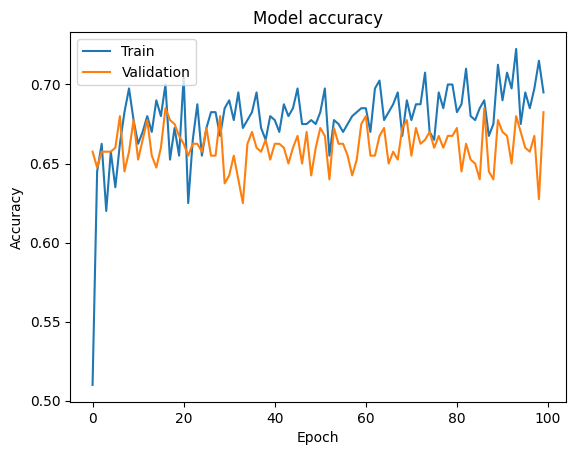

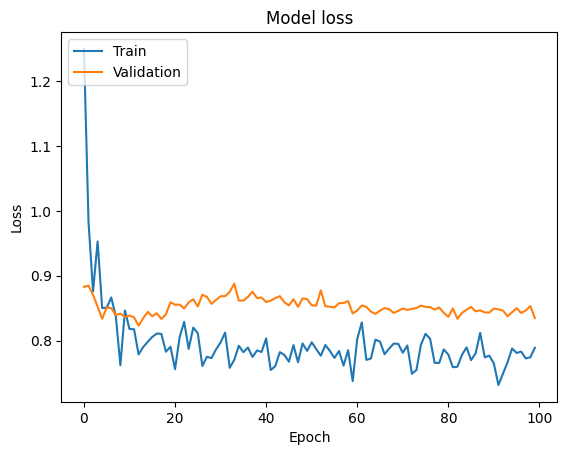

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n{classification_report(y_val, y_pred, target_names=label_encoder.classes_)}\n")

Random Forest Classification Report:
              precision    recall  f1-score   support

         pop       0.73      0.83      0.78        96
        rock       0.83      0.77      0.80       115
       salsa       0.83      0.86      0.84        85
      techno       0.92      0.85      0.88       104

    accuracy                           0.82       400
   macro avg       0.83      0.83      0.82       400
weighted avg       0.83      0.82      0.82       400


SVM Classification Report:
              precision    recall  f1-score   support

         pop       0.55      0.64      0.59        96
        rock       0.71      0.62      0.66       115
       salsa       0.77      0.80      0.79        85
      techno       0.85      0.83      0.84       104

    accuracy                           0.71       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.71      0.72       400


K-Nearest Neighbors Classification Report:
              precisi

In [44]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Clean Data
music_data = pd.read_csv('../1_data/raw/dataset.csv')
music_data.dropna(inplace=True)
music_data.drop_duplicates(inplace=True)

X = music_data.drop(columns = ["track_id", "artists", "album_name", "track_name", "track_genre"])
y = music_data["track_genre"]

# Encode the categorical target variable y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.5)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = accuracy_score(y_test, predictions)
print(score)

0.9987017543859649


In [46]:
X

,Unnamed: 0,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
113996,113996,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
113997,113997,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
113998,113998,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


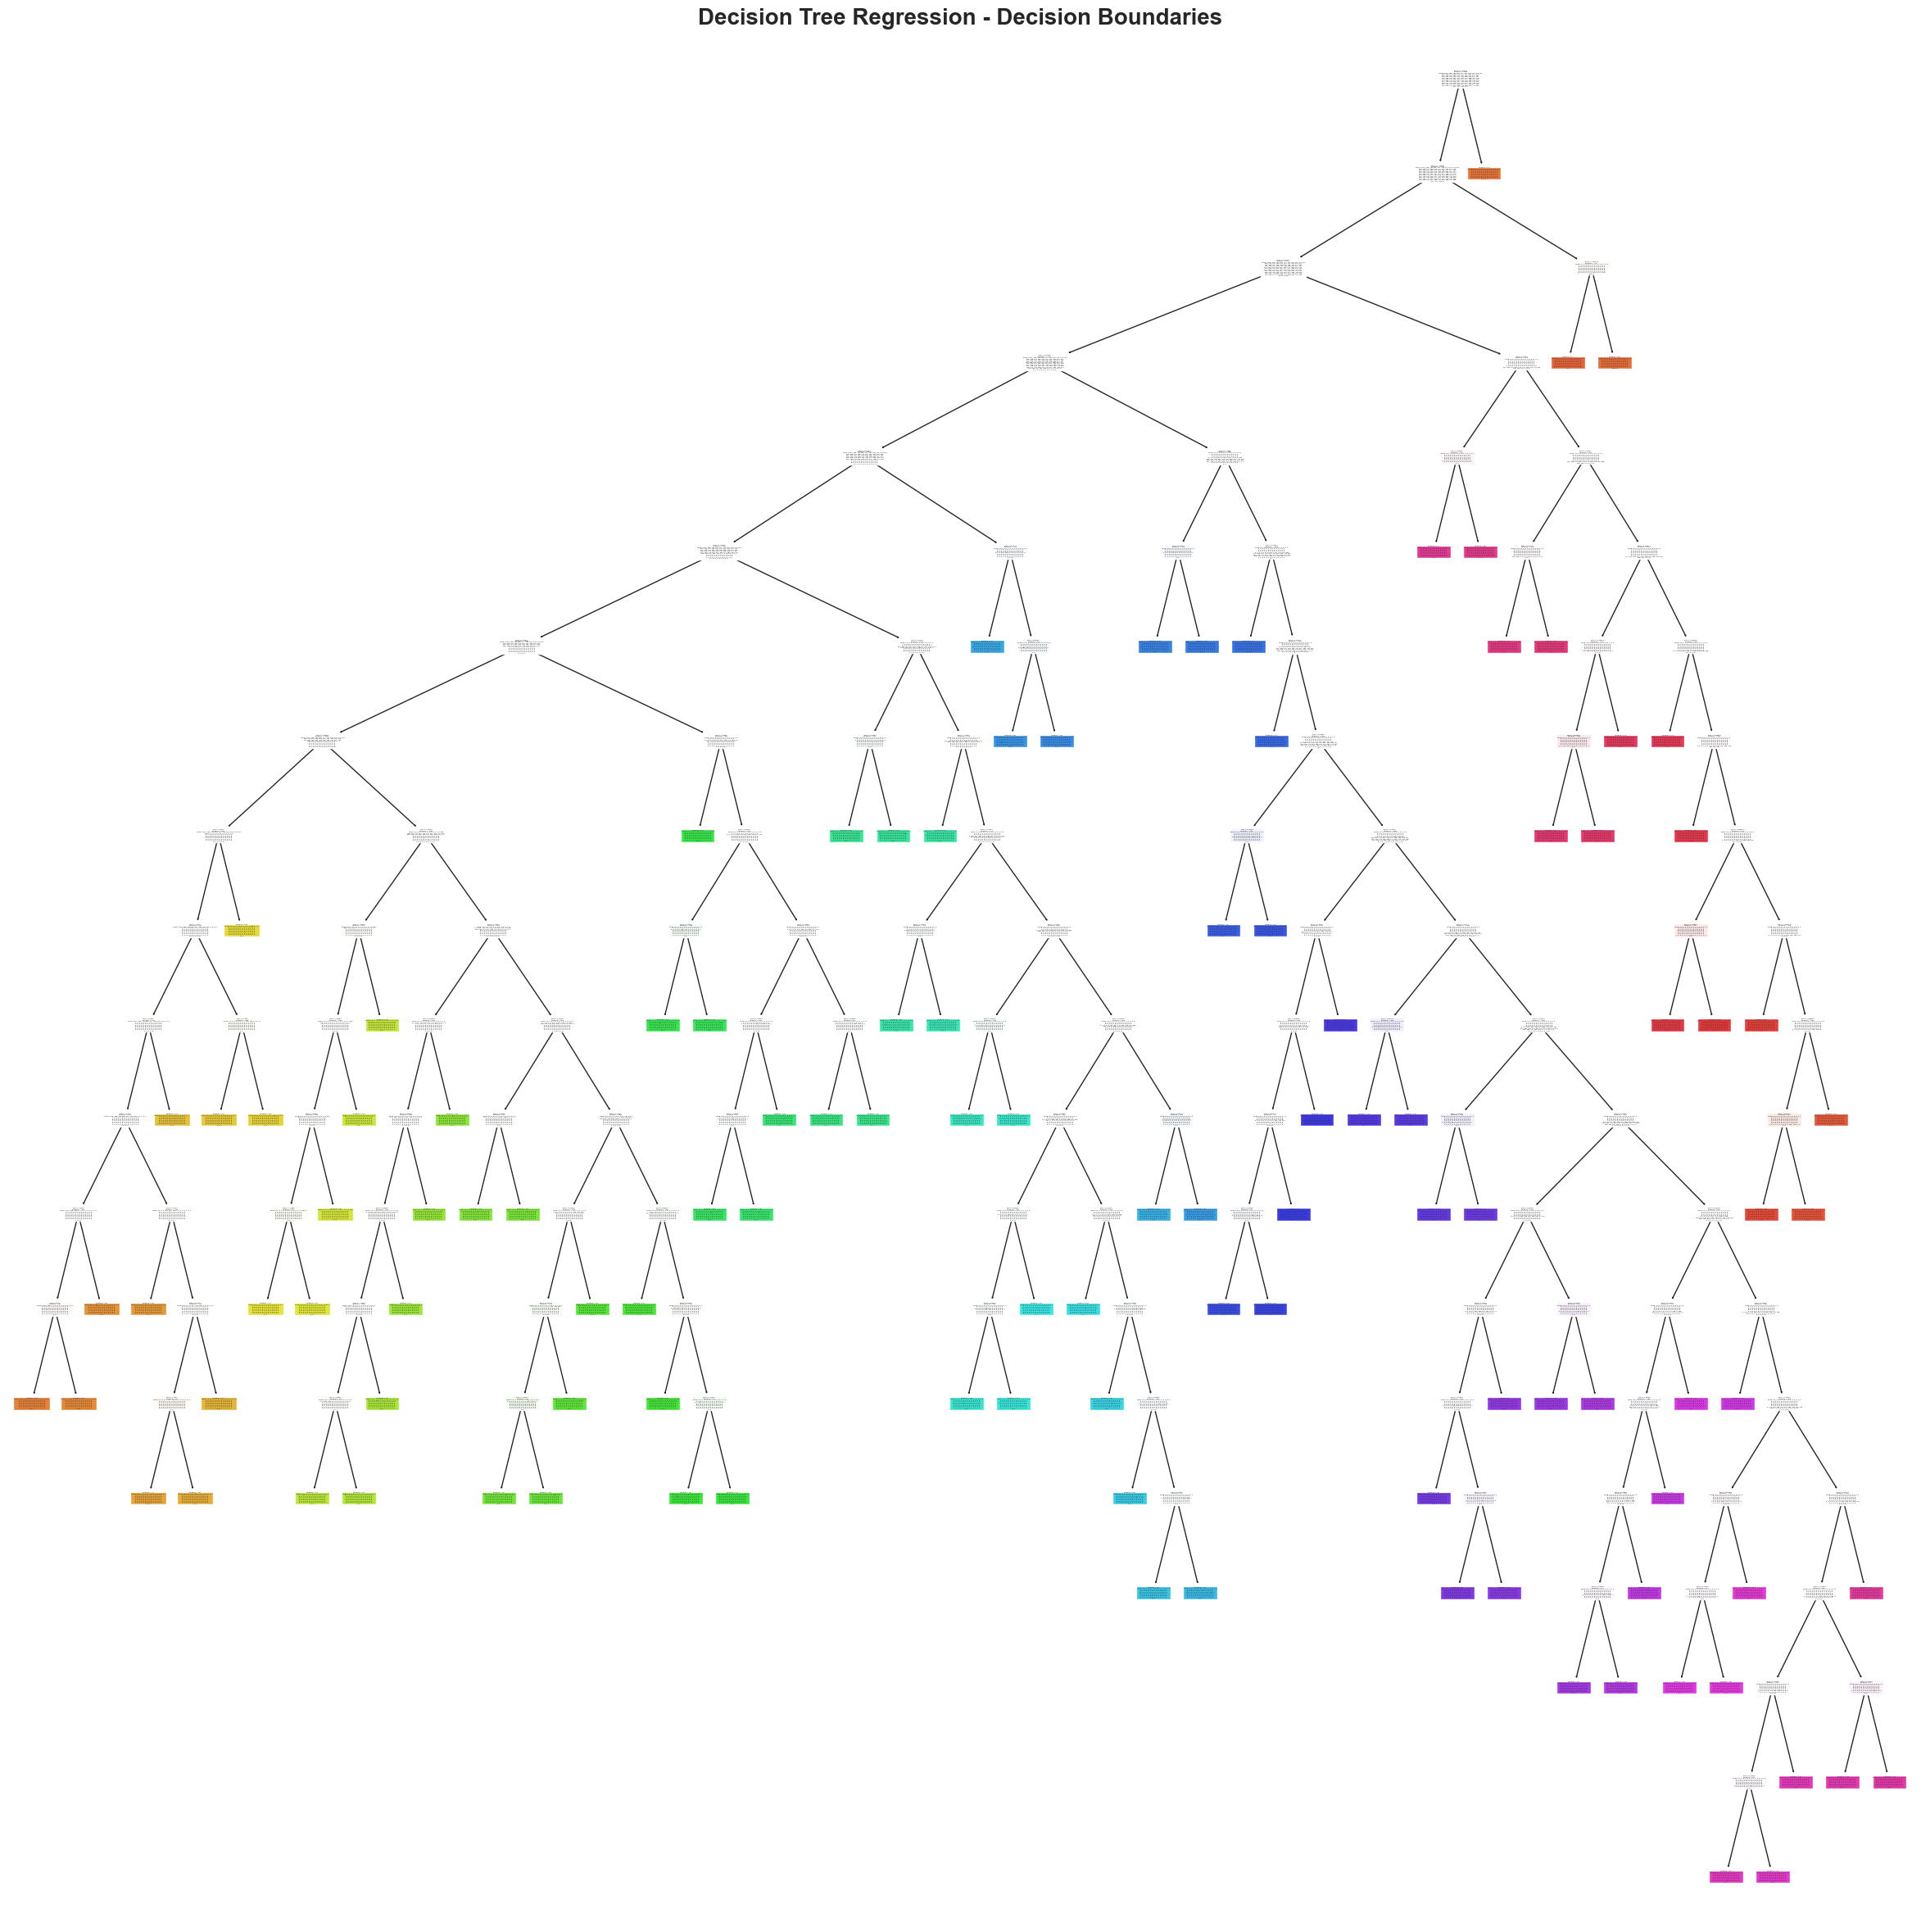

In [45]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the decision tree
plt.figure(figsize=(30,30))  # Adjust the figure size as needed
plot_tree(model, filled=True, feature_names=None, impurity=False)
plt.title('Decision Tree Regression - Decision Boundaries', fontsize=20, fontweight="bold")
# Save the plot as an image file with high resolution (300 dpi)
plt.savefig("q2_2_decision_boundaries.png", dpi=300, bbox_inches='tight')

plt.show()

In [29]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    

0.8811578947368421
0.19550877192982455
0.7432105263157894
0.9986491228070176
